# Dataset



In [1]:
import os

DATA_DIR = "/home/kdang/projects/spartDM/data/starmen/output_random_noacc"
os.chdir("/home/kdang/projects/spartDM/")
print("Current working directory:", os.getcwd())

Current working directory: /home/kdang/projects/spartDM


In [2]:
import numpy as np
from torch.utils.data import DataLoader

from src.data import StarmenDataset

starmen = StarmenDataset(DATA_DIR, split="train", nb_subject=5)
print(starmen.datas.shape)
train_loader = DataLoader(starmen, batch_size=2)

# x, x_prev = next(iter(train_loader))



(50, 5)


In [3]:
item = next(iter(train_loader))

In [ ]:
import numpy as np

from src.sadm.vivit import ViViT

vivit = ViViT(
    image_size = (64, 64),
    patch_size = (16, 16),
    num_frames = 9,
    depth = 3,
    heads = 3,
    dim_head=8
)

In [ ]:
import torch
from einops import rearrange
from einops.layers.torch import Rearrange
from torch import nn

patch_size = (16, 16) 
p1, p2 = patch_size
h, w = (4, 4)
patch_dim = int(np.prod(patch_size))


# c = vivit(x_prev)




temporal_layer = vivit.temporal_transformer.layers
len(temporal_layer)
vivit.temporal_dims


x_prev.shape
x = vivit.to_patch_embedding(x_prev)
b, t, n, d = x.shape
x += vivit.pos_embedding
x = vivit.dropout(x)
x = rearrange(x, "b t n d -> b (t n) d")
x = vivit.temporal_transformer(x)

print(f"After temporal transformer x.shape: {x.shape}")

# Perform space transformer

space_layer = vivit.space_transformer.layers
len(space_layer)


# vivit.space_dims
x = rearrange(x, "b (t n) d -> b d (t n)", b=2, t=9, n=16)
print(x.shape)

space_layer[0]

In [ ]:
vivit.temporal_transformer.layers[0]

vivit.space_dims

x_ups = vivit.space_transformer(x)
print(x_ups.shape)

# Conv2D last layers
conv = vivit.conv
x1 = conv[0](x_ups)
print(f"x upsample Conv2d shape: {x1.shape}")
x2 = conv[1](x1)
print(f"Rearrange shape: {x2.shape}")
conv[-1]
x3 = conv[-1](x2)
print(f"Output x: {x3.shape} (b c H W)")

## Visualize output

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


output_dir = "outdirs/x_gen_0.npy"
x_gen0 = np.load(output_dir)
x_gen0.shape

x_gen_store = np.load("outdirs/x_gen_store_0.npy")
print(x_gen_store.shape)

img = x_gen_store[0][0].squeeze()
plt.matshow(img, cmap="gray")

# Inference steps


In [2]:

from src.sadm.ddpm import DDPM
from src.sadm.ddpm_module import ContextUnet
from src.sadm.vivit import ViViT
from src.data import StarmenDataset
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import os
import shutil

from einops import rearrange
from src.sadm.utils import plot_multi_imgs



In [25]:
ckpt_path = "outdirs/ckpt/latest.pt"
sample_dir = "workdir/sadm_ep1000_T500_10sample/samples"

test_dataset = StarmenDataset(data_dir=DATA_DIR, split="train")
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

# idx_2 = next(iter(test_loader))

In [26]:
import numpy as np

idx = 720

x_origin = test_dataset.get_images_by_id(id=idx).astype(np.float32)
print(x_origin.shape)
x_gen = np.load(f"{sample_dir}/x_gen_{idx:03}.npy")
print(x_gen.shape)

x_masked = np.load(f"{sample_dir}/x_masked_{idx:03}.npy")
print(x_masked.shape)

# mask = idx_2["mask"]
# print(mask)

x_org_np = x_origin.squeeze()
x_masked_np = x_masked.squeeze()
x_gen_np = x_gen.squeeze()


error = x_org_np - x_gen_np
# error[np.abs(error) < 1e-10] = 0


(10, 1, 64, 64)
(10, 1, 64, 64)
(10, 1, 64, 64)


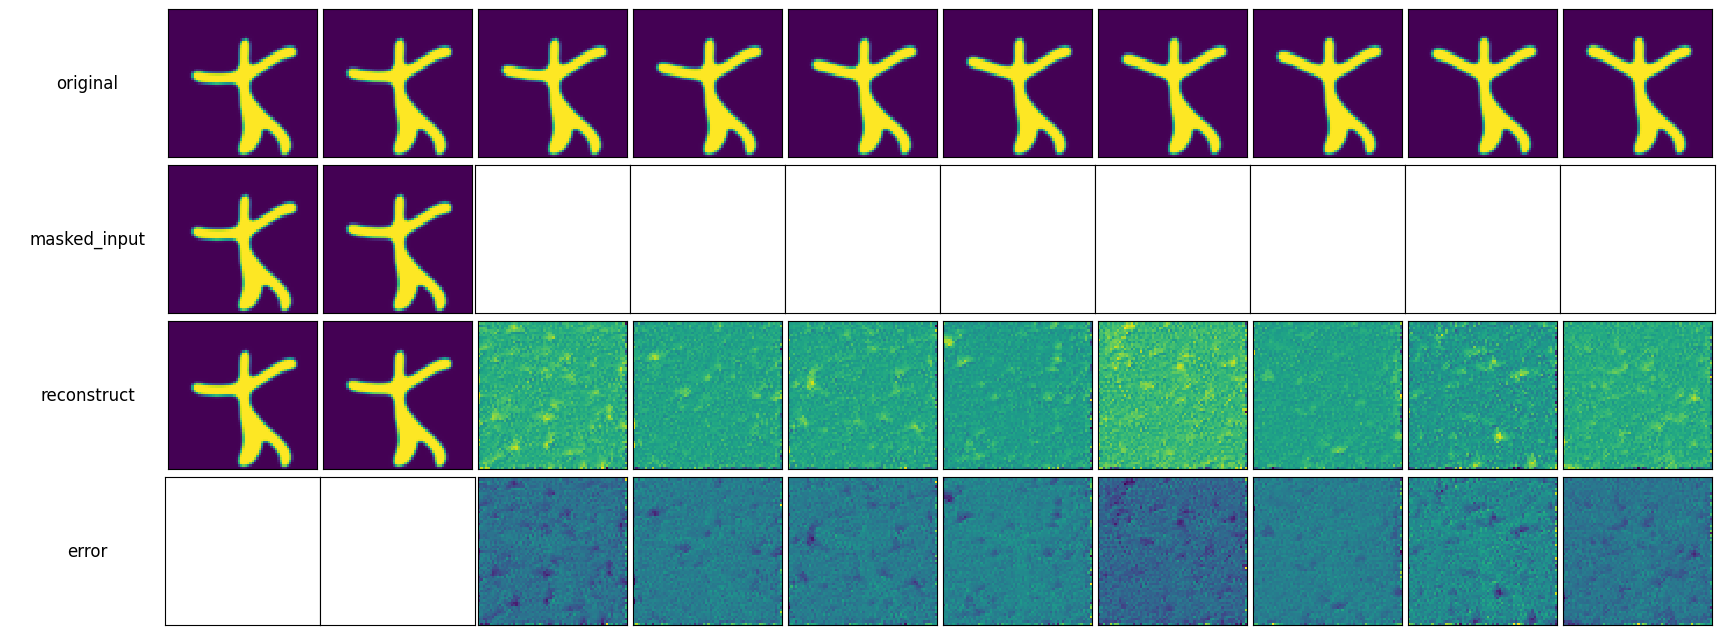

In [27]:


imgs = [x_org_np,
        x_masked_np,
        x_gen_np,
        error,
        ]

labels = ["original", "masked_input", "reconstruct", "error"]


plot_multi_imgs(imgs, labels, {"hspace": 0.05, "cmap": "viridis"})

## Analyze conditional signal $c_i$

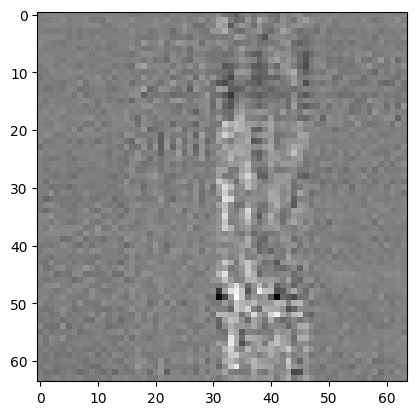

In [35]:
import pickle
import matplotlib.pyplot as plt

with open("debug_var/c_i.pkl", "rb") as f:
    ci = pickle.load(f)

ci = ci[0]

plt.imshow(ci.squeeze(), cmap="gray")